<a href="https://colab.research.google.com/github/farahelmashad/custom-naive-bayes-for-sentiment-analysis/blob/main/tweet_sentiment_naive_bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score

# Building Naive Bayes (Multinomial) from scratch

In [ ]:
class NaiveBayes(): #multinomial naive bayes
  def __init__(self,alpha=1.0):
    self.alpha=alpha
  def fit(self,X,Y):
    self.n_classes=len(np.unique(Y))
    self.n_features=X.shape[1] # V (unique vocab)
    self.p_classes=np.zeros((self.n_classes,1))
    self.m=X.shape[0] # no of docs / training examples
    self.feature_count=np.zeros((self.n_classes,self.n_features))
    for i in range(self.n_classes):
      x_class_i=X[Y==i]
      self.feature_count[i]=np.sum(x_class_i, axis=0)
      self.p_classes[i]=x_class_i.shape[0]/self.m
    self.log_probs=np.zeros((self.n_classes,self.n_features))
    self.log_probs=np.log((self.feature_count+self.alpha)/((np.sum(self.feature_count,axis=1,keepdims=True))+(self.alpha*self.n_features))) # log((count of the word in that class + alpha)/ total number of words in that class + alpha*|V|)
    self.log_class=np.log(self.p_classes).flatten()
  def predict(self,X):
    y_pred=np.argmax(self.predict_probabilities(X),axis=1)
    return y_pred
  def predict_probabilities(self,X):
    # shape of X is (n_examples,n_features) , shape of log_probs.T is (n_features, n_classes) , so their dot product will have the shape (n_examples,n_features), then we pick the max probability
    return np.dot(X,self.log_probs.T)+ self.log_class # log probability of class c + sum of log probabilities of each word in the document given this class c

  def score(self,X,Y):
    y_pred=self.predict(X)
    return accuracy_score(Y,y_pred)


# NLP Preprocessing for tweets to test the custom model

### Data Overview

In [ ]:
tweets=pd.read_csv('/content/train.csv',encoding='utf-8')

In [ ]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [ ]:
tweets.drop(columns=['textID','selected_text'],inplace=True)

In [ ]:
tweets['sentiment']=tweets['sentiment'].map({'negative':0,'positive':1})

In [ ]:
tweets['sentiment'].value_counts(normalize=True)

,proportion
sentiment,
neutral,0.404570
positive,0.312288
negative,0.283141


In [ ]:
tweets=tweets.loc[tweets['sentiment']!='neutral']

In [ ]:
tweets.shape

(27481, 2)

In [ ]:
tweets.isnull().sum()

,0
text,1
sentiment,11118


In [ ]:
tweets.loc[tweets["text"].isnull(),:]

,text,sentiment
314,NaN,NaN


In [ ]:
tweets.dropna(axis=0, inplace=True)

In [ ]:
tweets.sample(3)

,text,sentiment
12283,I dunno...I thought I was funny,0.0
19579,I feel like a Truck just hit me too! I also R...,0.0
6129,I think the UPS web site hates me now. Still n...,0.0


In [ ]:
df=tweets.copy(deep=True)

In [ ]:
df['character_length']=df['text'].apply(len)
df['word_count']=df['text'].apply(lambda x: len(x.split()))

In [ ]:
print(df[['character_length','word_count']].describe())

       character_length   word_count
count      16363.000000  16363.00000
mean          70.451934     13.28265
std           34.889314      6.80974
min            5.000000      1.00000
25%           42.000000      8.00000
50%           66.000000     12.00000
75%           98.000000     19.00000
max          141.000000     33.00000


In [ ]:
import re

In [ ]:
print("Number of tweets containing urls:", tweets['text'].str.contains(r"https?://\w+").sum())
print("Number of tweets containing mentions:", tweets['text'].str.contains(r"@\w+").sum())
print("Number of tweets containing hashtags: ", tweets['text'].str.contains(r"#\w+").sum())
print("Number of tweets containing html tags (bc data is scraped): ", tweets['text'].str.contains(r"<[^>]>").sum())
print("Number of tweets containing emojis(using emoji unicode)",tweets['text'].str.contains('[^\x00-\x7F]').sum())

Number of tweets containing urls: 642
Number of tweets containing mentions: 42
Number of tweets containing hashtags:  309
Number of tweets containing html tags (bc data is scraped):  1
Number of tweets containing emojis(using emoji unicode) 78


In [ ]:
!pip install ftfy

In [ ]:
import ftfy
tweets['text'] = tweets['text'].apply(lambda x: ftfy.fix_text(x) if isinstance(x, str) else x)
tweets['text'] = tweets['text'].str.replace('`', "'", regex=False)

In [ ]:
mask = tweets['text'].str.contains('\ufffd', na=False)
tweets = tweets[~mask].reset_index(drop=True)

### Data Cleaning

In [ ]:
## removing html using bs4
from bs4 import BeautifulSoup
def remove_html(text):
  return BeautifulSoup(text).get_text()


In [ ]:
tweets['text']=tweets['text'].apply(remove_html)

In [ ]:
## removing urls:
def remove_urls(text):
  text=re.sub(r"https?://\S+",'',text)
  text=re.sub(r"www\.\S+",'',text)
  return text

In [ ]:
tweets['text']=tweets['text'].apply(remove_urls)

In [ ]:
## remove mentions:
def remove_mentions(text):
  text=re.sub(r"@\w+",'',text)
  return text

In [ ]:
tweets['text']=tweets['text'].apply(remove_mentions)

In [ ]:
## remove hashtags:
# will keep the word itself for context
def remove_hashtags(text):
  text=re.sub(r"#(\w+)",r"\1",text)
  return text

In [ ]:
tweets['text']=tweets['text'].apply(remove_hashtags)

In [ ]:
# handle emojis (will turn into words instead of removing them totally)
!pip install emoji

In [ ]:
import emoji

In [ ]:
def extract_emojis(text):
    return emoji.demojize(text, delimiters=(' ', ' ')).replace('_',' ').replace('-',' ')

In [ ]:
tweets['text']=tweets['text'].apply(extract_emojis)

In [ ]:
!pip install contractions

In [ ]:
## handling contractions (can't/don't/won't) before removing punctuation
import contractions

In [ ]:
tweets['text']=tweets['text'].apply(lambda x: contractions.fix(x))

In [ ]:
import string

In [ ]:
def remove_punctuation(text):
  text = text.translate(str.maketrans('', '', string.punctuation))
  return text

In [ ]:
tweets['text']=tweets['text'].apply(remove_punctuation)

In [ ]:
tweets['text']=tweets['text'].apply(lambda x: x.lower())

In [ ]:
## removing numbers: (wont matter in sentimenr):
def remove_numbers(text):
  return re.sub(r"\b\d+\b",'',text)

In [ ]:
tweets['text']=tweets['text'].apply(remove_numbers)

In [ ]:
def remove_repeated_chars(text):  # remove repeated chars zay yaaaayyy and so on
  text=re.sub(r"(.)\1{2,}",r"\1\1",text)
  return text

In [ ]:
tweets['text']=tweets['text'].apply(remove_repeated_chars)

In [ ]:
# normalize extra whitespaces:
def remove_extra_whitespaces(text):
  text=re.sub(r"\s+",' ',text).strip()
  return text

In [ ]:
tweets['text']=tweets['text'].apply(remove_extra_whitespaces)

In [ ]:
print(tweets.sample(5))

                                                   text  sentiment
1012  iphone today i want to see the morning of in v...        0.0
6439  i do but i am on a strict diet ugh i feel like...        0.0
8078                          i got a of hw to do 2nite        0.0
6295                             i am sorry that stinks        0.0
7521                my head hurts so bad i could scream        0.0


### Tokenization

In [ ]:
import nltk
nltk.download('punkt',quiet=True)
nltk.download('punkt_tab',quiet=True)
nltk.download('stopwords',quiet=True)
nltk.download('wordnet',quiet=True)
nltk.download('averaged_perceptron_tagger_eng',quiet=True)

True

In [ ]:
!pip install nltk spacy

In [ ]:
from nltk.tokenize import word_tokenize

In [ ]:
tweets['text']=tweets['text'].apply(word_tokenize)

### Stopword Removal

In [ ]:
from nltk.corpus import stopwords

In [ ]:
# wont be removing negation bc it's important
stop_words=set(stopwords.words('english'))

In [ ]:
negative_words={'no', 'not', 'nor', 'neither', 'never', 'nobody', 'nothing','nowhere', 'cannot','can\'t','won\'t'}

In [ ]:
neg_in_stopwords=stop_words.intersection(negative_words)

In [ ]:
stop_words_without_negation=stop_words-neg_in_stopwords

In [ ]:
stop_words_without_negation

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 "he's",
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 "i'll",
 "i'm",
 "i've",
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 

In [ ]:
neg_in_stopwords

{'no', 'nor', 'not', "won't"}

In [ ]:
def remove_stop_words(text):
  return [token for token in text if token not in stop_words_without_negation]

In [ ]:
tweets['text']=tweets['text'].apply(remove_stop_words)

### POS and Lemmatization

In [ ]:
tweets.sample()

,text,sentiment
9901,"[painful, sound, world, crying, someone, love,...",0.0


In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

In [ ]:
def get_pos(word):
  if word.startswith('J'):
    return wordnet.ADJ
  elif word.startswith('V'):
    return wordnet.VERB
  elif word.startswith('N'):
    return wordnet.NOUN
  elif word.startswith('R'):
    return wordnet.ADV
  else:
    return wordnet.NOUN


In [ ]:
wordnetlemmatizer=WordNetLemmatizer()

In [ ]:
nltk.download('averaged_perceptron_tagger_eng',quiet=True)

True

In [ ]:
def lemmatize_tokens(tokens):
    pos_tags = nltk.pos_tag(tokens)
    lemmatizations=[wordnetlemmatizer.lemmatize(word, get_pos(tag))for word, tag in pos_tags]
    return lemmatizations

In [ ]:
tweets['text']=tweets['text'].apply(lemmatize_tokens)

In [ ]:
tweets.sample()

,text,sentiment
1931,"[poor, baby, get, first, booboo, cause, lol]",0.0


In [ ]:
tweets['text']=tweets['text'].apply(lambda x: ' '.join(x))

### Vectorization

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tweets['text'], tweets['sentiment'], test_size=0.2,stratify=tweets['sentiment'])

In [ ]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2),max_features=15000,min_df=2,max_df=0.95)
X_train_cv = count_vectorizer.fit_transform(X_train)
X_test_cv  = count_vectorizer.transform(X_test)

In [ ]:
X_train_cv

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 108249 stored elements and shape (13028, 11451)>

### Comparing custom Naive Bayes class against Sklearn's MultinomialNB

In [ ]:
from sklearn.metrics import accuracy_score,classification_report

In [ ]:
#finding the best alpha (for Laplacian Smoothing) using gridsearchcv
from sklearn.model_selection import GridSearchCV
params = {'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]}
grid = GridSearchCV(MultinomialNB(), params, cv=5, scoring='accuracy')
grid.fit(X_train_cv, y_train)

GridSearchCV(cv=5, estimator=MultinomialNB(),
             param_grid={'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]},
             scoring='accuracy')

In [ ]:
print("Best alpha:", grid.best_params_)
print("Best CV score:", grid.best_score_)

Best alpha: {'alpha': 2.0}
Best CV score: 0.8725053213976899


In [ ]:
#testing the custom NB
custom_naive_bayes=NaiveBayes(alpha=2.0)
custom_naive_bayes.fit(X_train_cv.toarray(),y_train)
y_pred=custom_naive_bayes.predict(X_test_cv.toarray())

In [ ]:
print(classification_report(y_test, custom_naive_bayes.predict(X_test_cv.toarray())))

              precision    recall  f1-score   support

         0.0       0.85      0.88      0.87      1549
         1.0       0.89      0.86      0.87      1709

    accuracy                           0.87      3258
   macro avg       0.87      0.87      0.87      3258
weighted avg       0.87      0.87      0.87      3258



In [ ]:
#testing sklearn's MultinomialNB
sklearn_nb=MultinomialNB(alpha=2.0)
sklearn_nb.fit(X_train_cv.toarray(),y_train)
y_pred=sklearn_nb.predict(X_test_cv.toarray())

In [ ]:
print(classification_report(y_test, sklearn_nb.predict(X_test_cv.toarray())))

              precision    recall  f1-score   support

         0.0       0.85      0.88      0.87      1549
         1.0       0.89      0.86      0.87      1709

    accuracy                           0.87      3258
   macro avg       0.87      0.87      0.87      3258
weighted avg       0.87      0.87      0.87      3258



In [ ]:
# Almost identical precision and recall scores!

In [ ]:
# trying tfidf instead of BoW (count vectorizer)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=15000, min_df=2, max_df=0.95, sublinear_tf=True)
X_train_tf = tfidf.fit_transform(X_train)
X_test_tf  = tfidf.transform(X_test)

nb_tfidf = MultinomialNB(alpha=2.0)
nb_tfidf.fit(X_train_tf, y_train)
print(classification_report(y_test, nb_tfidf.predict(X_test_tf)))


              precision    recall  f1-score   support

         0.0       0.87      0.85      0.86      1549
         1.0       0.86      0.89      0.88      1709

    accuracy                           0.87      3258
   macro avg       0.87      0.87      0.87      3258
weighted avg       0.87      0.87      0.87      3258



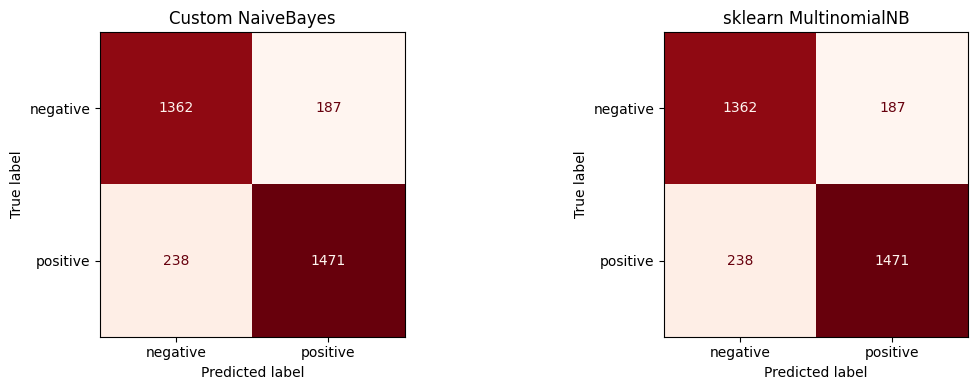

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, (preds, title) in zip(axes, [
    (custom_naive_bayes.predict(X_test_cv.toarray()),'Custom NaiveBayes'),
    (sklearn_nb.predict(X_test_cv),'sklearn MultinomialNB'),
]):
    cm = confusion_matrix(y_test, preds)
    disp = ConfusionMatrixDisplay(cm, display_labels=['negative','positive'])
    disp.plot(ax=ax, colorbar=False, cmap='Reds')
    ax.set_title(title)

plt.tight_layout()
plt.show()


In [ ]:
feature_names = count_vectorizer.get_feature_names_out()
log_prob_diff = custom_naive_bayes.log_probs[1]-custom_naive_bayes.log_probs[0]

top_positive_idx = np.argsort(log_prob_diff)[-20:][::-1]
top_negative_idx = np.argsort(log_prob_diff)[:20]
pos=[]
print('Top 20 n-grams most associated with positive sentiment:')
for idx in top_positive_idx:
        pos.append(feature_names[idx])
print(pos)
negs=[]
print('\nTop 20 n-grams most associated with negative sentiment:')
for idx in top_negative_idx:
    negs.append(feature_names[idx])
print(negs)

Top 20 n-grams most associated with positive sentiment:
['happy mother', 'thank', 'mother day', 'day mom', 'amaze', 'hopefully', 'thanks', 'awesome', 'welcome', 'good morning', 'mother', 'great day', 'good night', 'happy star', 'wonderful', 'good luck', 'happy', 'day mother', 'love', 'happy birthday']

Top 20 n-grams most associated with negative sentiment:
['sad', 'hate', 'suck', 'bore', 'go miss', 'make sad', 'hurt', 'pain', 'depress', 'sorry', 'stupid', 'fail', 'wtf', 'headache', 'sick', 'sorry not', 'sorry hear', 'not like', 'jealous', 'poor']
